<a href="https://colab.research.google.com/github/lulu643/Black-Scoles-Simulation/blob/main/Black_Scholes_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preperation: Import the Modules

In [ ]:
!pip install jqdatasdk

In [2]:
import os
import numpy as np
import pandas as pd
import csv
from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import matplotlib.pyplot as plt
from google.colab import data_table
data_table.enable_dataframe_formatter()
# pd.set_option('display.max_columns', None)
from jqdatasdk import *
auth('13568904907','LiuSihan1022')  # authentification of account

auth success 


In [3]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
path = Path('/content/drive/MyDrive/Spring 2022 Independent Study Louisa/Simulation')
os.chdir(path) # sets directory to "path"
os.getcwd() # prints directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Spring 2022 Independent Study Louisa/Simulation'

# Balck Scholes Formula

**The Formula**
$$
C=N\left(d_{1}\right) S_{t}-N\left(d_{2}\right) K e^{-r t} \\
\text { where } d_{1}=\frac{\ln \frac{S_{t}}{K}+\left(r+\frac{\sigma^{2}}{2}\right) t}{\sigma \sqrt{t}} \\
\text { and } d_{2}=d_{1}-\sigma \sqrt{t}
$$

$C$ = call option price  
$N$ = CDF of the normal distribution  
$S_t$ = index price  
$K$ = strike price/exercise price  
$r$ = risk-free interest rate  
$t$ = time to maturity  
$σ$ = volatility rate of the stock

**Assumptions for the model**  
- It's for European calls. 
- No dividends are paid out during the option’s life. 
- No transaction and commissions costs in buying the option. 
- The risk-free rate and volatility of the underlying asset are known and constant.
- The returns on the underlying are normally distributed. 

In [4]:
def d1(S,K,T,r,sigma):
    return (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))

def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)

def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

def bs_put(S,K,T,r,sigma):
    return K*exp(-r*T)-S+bs_call(S,K,T,r,sigma)

# Options

## Option Selection

**Criteria**
1. European option
2. Call option
2. INDEX based 
4. Not adjusted in the past
5. Mature before '2022-03-01'
5. Life span is longer than 1 month

**Index Based Options**  

There are 3 types of underlying_type: 'ETF', 'INDEX', 'FUTURE', which one should I choose? -> 'INDEX' 

**Key ponts**:
- An exchange-traded fund (ETF) is essentially a mutual fund that trades like a stock.
- ETF options are traded the same as stock options, which are "American style" and settle for shares of the underlying ETF.
- Index options are settled “European style,” which means they are settled in cash.
- Index options cannot be exercised early while ETF options can.

**Reference**  
https://www.investopedia.com/articles/optioninvestor/10/etf-options-v-index-options.asp  

In [5]:
last_day = datetime(2022, 3, 1, 0, 0)

df = opt.run_query(query(opt.OPT_CONTRACT_INFO).filter
                   (opt.OPT_CONTRACT_INFO.exercise_date != None,
                    opt.OPT_CONTRACT_INFO.contract_type == 'CO',
                    opt.OPT_CONTRACT_INFO.underlying_type == 'INDEX',
                    opt.OPT_CONTRACT_INFO.is_adjust == 0,
                    opt.OPT_CONTRACT_INFO.expire_date < last_day))

df = df.loc[(df['expire_date'] - df['list_date']).dt.days > 31]

options = list(df.code)
print('There are', len(options), 'opions satifying this condition.')

There are 673 opions satifying this condition.


In [6]:
# Output the options selection into excel
# df.to_excel("options.xlsx")

## Testing Sets

Further select options from what I obtained in the last step.

**Testing Set 1: Similar options**  

In [7]:
test_options1 = ['IO2202-C-4300.CCFX','IO2202-C-4400.CCFX','IO2202-C-4500.CCFX',
                'IO2202-C-4600.CCFX','IO2202-C-4800.CCFX','IO2202-C-4900.CCFX',
                'IO2202-C-5000.CCFX','IO2202-C-5100.CCFX','IO2202-C-5200.CCFX',
                'IO2202-C-5300.CCFX','IO2202-C-5400.CCFX','IO2202-C-5500.CCFX']

| Code      | Underlying | Maturity Date | Type |  Strike Price |
| ----------- | ----------- |----------- |----------- |----------- |
| IO2202-C-4300.CCFX | 000300.XSHG | 2022-02-18 | European Call | 4300|
| IO2202-C-4400.CCFX | 000300.XSHG |2022-02-18 |European Call | 4400|
| IO2202-C-4500.CCFX | 000300.XSHG |2022-02-18 |European Call | 4500|
| IO2202-C-4600.CCFX | 000300.XSHG |2022-02-18 |European Call | 4600|
| ... | ... |... |... | ...|

**Testing Set 2: Randomly pick**

Randomly pick 10 options from the ones satified the criteria.

In [8]:
import random

test_options2 = random.sample(options, 10)
print('The options selected are: \n', test_options2)

The options selected are: 
 ['IO2112-C-4950.CCFX', 'IO2009-C-4000.CCFX', 'IO2002-C-3950.CCFX', 'IO2003-C-4450.CCFX', 'IO2112-C-5800.CCFX', 'IO2010-C-4100.CCFX', 'IO2005-C-4350.CCFX', 'IO2101-C-4650.CCFX', 'IO2112-C-4400.CCFX', 'IO2007-C-3550.CCFX']


# Risk-free Rate

**Data Source**: offcial website of Ministry of Finance of the People's Republic of China  
https://yield.chinabond.com.cn/cbweb-czb-web/czb/moreInfo?locale=cn_ZH   

**Data Stored in the File**: 'bonds.xlsx'

In [9]:
# get information of bonds from excel file
bonds_df = pd.read_excel('bonds.xlsx')
print(bonds_df.head())

        date  3 months  6 months  1 year  2 years  3 years  5 years  7 years  \
0 2022-03-15      1.93      2.00    2.13     2.31     2.33     2.57     2.80   
1 2022-03-14      1.81      1.96    2.07     2.25     2.28     2.48     2.75   
2 2022-03-11      1.90      2.04    2.09     2.28     2.32     2.52     2.77   
3 2022-03-10      1.90      2.05    2.12     2.30     2.33     2.59     2.83   
4 2022-03-09      1.89      2.03    2.12     2.29     2.32     2.57     2.83   

   10 years  30 years  
0      2.82      3.39  
1      2.77      3.36  
2      2.79      3.37  
3      2.85      3.41  
4      2.84      3.40  


In [10]:
# If I set it manually
rf_rate = 0.02

# Compute Parameters

In [11]:
class Option:
    
    def __init__(self, code):
        self.code = code
        self.info = opt.run_query(query(opt.OPT_CONTRACT_INFO).filter(opt.OPT_CONTRACT_INFO.code==self.code))
        self.contract_type = self.info['contract_type'].iloc[0]
        
        self.underlying_symbol = self.info['underlying_symbol'].iloc[0]
        self.underlying_name = self.info['underlying_name'].iloc[0]
        self.underlying_type = self.info['underlying_type'].iloc[0]
        
        self.list_date = self.info['list_date'].iloc[0]
        self.expire_date = self.info['expire_date'].iloc[0]
        self.exercise_price = self.info['exercise_price'].iloc[0]
        
    def get_code(self):
        return self.code
    
    def get_underlying(self):
        return self.underlying_symbol
    
    def get_listdate(self):
        return self.list_date
    
    def get_expiredate(self):
        return self.expire_date
        
    def get_price(self, start_date = None, end_date = None):
        
        if start_date == None:
            start_date = self.list_date 
        if end_date == None:
            end_date = self.expire_date
            
        df = get_price(self.code, start_date=start_date, end_date=end_date, frequency='1d', fields=['close'], panel=False)
        # the returned does not have value for non-trading days, automatically skipped
        return df
        
    def get_strike_price(self):
        return self.exercise_price
    
    def get_time_to_maturity(self, date):
#         if type(date) == 'str':
#             date = datetime.strptime(date,"%Y-%m-%d").date()
#         if not isinstance(date, datetime):
        date = date.date()
        t = (self.expire_date - date).days / 365
        return t

    def get_estimated_rf_rate(self, date, bonds_info):
        # to get the discounting factor that is most suitable
        # for discounting cash in the computation of Black Scholes price
        
        time_to_maturity = self.get_time_to_maturity(date)
        
        bond_types = [0.25, 0.5, 1, 2, 3, 5, 7, 10, 30]
        bond_type_match = {0.25:'3 months', 0.5:'6 months', 1:'1 year', 2:'2 years', 3:'3 years', 5:'5 years', 7:'7 years', 10:'10 years', 30:'30 years'}
        bond_choice = bond_type_match[min(bond_types, key=lambda x:abs(time_to_maturity))]
        estimated_rf_rate = bonds_info.loc[bonds_info['date'] == date][bond_choice].iloc[0]
        estimated_rf_rate *= 0.01  # Because in bonds_info, the numbers are shown in percentage e.g. 2.89
        
        return estimated_rf_rate
    
    
    def get_underlying_price(self, start_date=None, end_date=None):

        if start_date == None:
            start_date = self.list_date 
        if end_date == None:
            end_date = self.expire_date

        df = get_price(self.underlying_symbol, start_date=start_date, end_date=end_date, frequency='1d', fields=['close'], panel=False)
        return df['close']


    def compute_yearly_vol(self, start_date, end_date, rolling_window):
        """
        the unit of rolling windows is "day"
        """
        df = get_price(self.underlying_symbol, start_date=start_date, end_date=end_date, frequency='1d', fields=['close','pre_close'], panel=False)
        df['close'] = df['close'].astype('float64')
        df['pre_close'] = df['pre_close'].astype('float64')
        df['auxiliary'] = np.log(df.close/df.pre_close)  # based on the assumption in the model
        yearly_vol = np.sqrt(253) * (df['auxiliary'].rolling(rolling_window).std()).to_frame()  # Minimum number of observations required = window size, else np.nan
        return yearly_vol


    def compute_bs_value(self, bonds_info, volatility_window, start_date = None, end_date = None):

        if start_date == None:
            start_date = self.list_date 
        if end_date == None:
            end_date = self.expire_date
        
        df = self.compute_yearly_vol(start_date, end_date, volatility_window)
        df.columns = ['yearly_vol']
        df['time_to_maturity'] = pd.Series({x: self.get_time_to_maturity(x) for x in df.index}).to_frame()
        df['rf_rate'] = pd.Series({x: self.get_estimated_rf_rate(x, bonds_info) for x in df.index}).to_frame()
#         df['rf_rate'] = pd.Series({x: 0.02 for x in df.index}).to_frame()
        df_temp = self.get_underlying_price(start_date, end_date).to_frame()
        df_temp.columns = ['underlying_price']
        df = df.merge(df_temp, how='inner', left_index=True, right_index=True)        
        
        df['bs_price'] = df.apply(lambda row: bs_call(row['underlying_price'], self.get_strike_price(), row['time_to_maturity'], row['rf_rate'], row['yearly_vol']), axis=1)

        return df['bs_price']

    def at_the_money_dates(self, start_date=None, end_date=None):

        if start_date == None:
            start_date = self.list_date 
        if end_date == None:
            end_date = self.expire_date

        strike_price = self.get_strike_price()
        underlying_prices = self.get_underlying_price(start_date, end_date).to_frame()
        underlying_prices['pre_close'] = underlying_prices.close.shift(1)

        # the way to decide whether it is at the money
        df = underlying_prices.loc[(underlying_prices['close'] - strike_price)*(underlying_prices['pre_close'] - strike_price) <= 0]
        at_the_money_dates = df.index.tolist()

        return at_the_money_dates

        

# Result Analysis Functions

Plot real option price and price computed using Black Scholes formula on a same graph.

In [12]:
def plot_real_BSres(option, volatility_window):

    at_the_money_dates = option.at_the_money_dates()

    # plot price of underlying security "000300.XSHG"
    ax1 = plt.subplot(1, 2, 1)
    stock_price = option.get_underlying_price(option.get_listdate(), option.get_expiredate())
    stock_price.plot(ax=ax1, title='Underlying Index Price', figsize=(10,4))
    # add lines of at the money dates
    for date in at_the_money_dates:
      plt.axvline(x=date, linewidth=0.2, color='red')

    # plot real price of the option and Black Schoels computed price of the option
    real_price = option.get_price()
    bs_price = option.compute_bs_value(bonds_df, volatility_window).to_frame()  
    
    ax2 = plt.subplot(1, 2, 2)
    real_price.plot(ax=ax2, title='option ' + option.get_code(), figsize=(10,4))
    bs_price.plot(ax=ax2)
    # add lines of at the money dates
    for date in at_the_money_dates:
      plt.axvline(x=date, linewidth=0.2, color='r')

    # set_labels
    ax2.set_xlabel('time')
    ax2.set_ylabel('price')
    plt.tight_layout()
    plt.show()
    
    # save figures
    # a = option.get_code().replace('.', '')
    # plt.savefig( a + '_253scale')

    return bs_price, real_price

Print evaluation metrics.

In [13]:
def model_evaluation(bs_price, real_price, code):
    
    df = bs_price.merge(real_price, how='inner', left_index=True, right_index=True)
    df.columns = ['bs_price', 'real_price']
    df['dif_price'] = df.bs_price - df.real_price
    df['dif_perc'] = df.dif_price/df.real_price
    df['dif_perc_abs'] = abs(df['dif_perc'])
    
    mean = round(df['dif_perc'].mean() * 100, 2)
    std = round(df['dif_perc'].std() * 100, 2)
    max_dif = round(df['dif_perc_abs'].max() * 100, 2)
    max_date = df[['dif_perc_abs']].idxmax().iloc[0].date()
    
    s = f''' 
    option {code}
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : {mean} %
    Std                 : {std} %
    Max (in abs value)  : {max_dif}% ({max_date})
    ---------------------------
    '''
    print(s)
    
    return (mean, std, max_dif, max_date)


Store results to a file -> 'result_analsys.csv' 

In [14]:
def result_to_file(file, option, volatility_window, mean, std, max_dif, max_date):
    today = datetime.today().strftime('%Y-%m-%d')
    current_time = datetime.now().strftime("%H:%M:%S")

    if not os.path.exists(file):
      lst = ['test date', 'test_time', 'code', 'underlying_symbol','list_date', 'expire_date', 'strike_price', 'vol_window', 'dif%_mean', 'dif%_std', 'dif%_max(abs)','dif%_max_date']
      with open(file, 'w') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(lst)

    lst2 = [today, current_time, option.get_code(), option.get_underlying(), option.get_listdate(), 
            option.get_expiredate(), option.get_strike_price(), volatility_window, mean, std, max_dif, max_date ]
    
    with open(file, 'a') as f2: 
      writer = csv.writer(f2, delimiter=',')
      writer.writerow(lst2) 

## Main Function

Parameters  

There are five parameters for computation of Black Scholes price

|$S_t$| $K$ | $r$| $t$ | $σ$ |
| ----------- | ----------- |----------- |----------- |----------- |
|index price |strike price/exercise price |risk-free interest rate |time to maturity |volatility rate of the stock|


In [15]:
# the rf_rate is obtained from bonds_df
# time window to compute volatility is 
volatility_window = 21

# all other parameters are associated with the specific option

Main Function

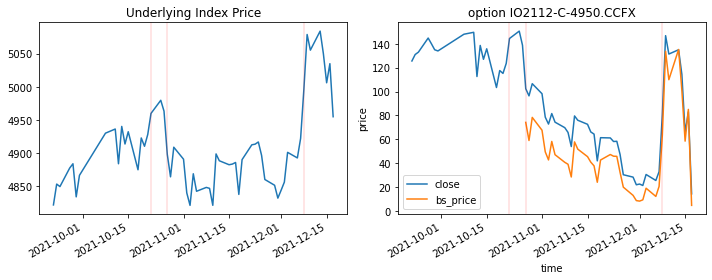

 
    option IO2112-C-4950.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : -33.44 %
    Std                 : 16.14 %
    Max (in abs value)  : 66.94% (2021-12-17)
    ---------------------------
    


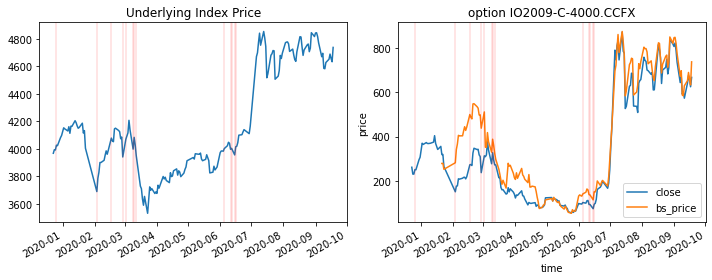

 
    option IO2009-C-4000.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : 27.26 %
    Std                 : 33.53 %
    Max (in abs value)  : 123.26% (2020-04-14)
    ---------------------------
    


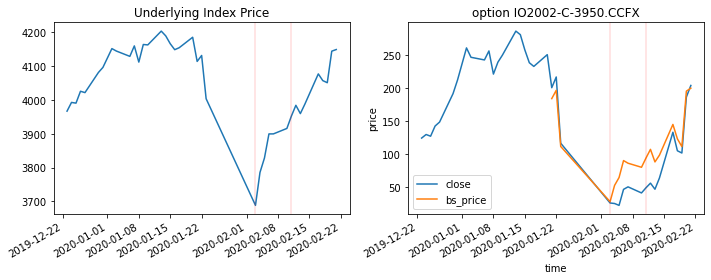

 
    option IO2002-C-3950.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : 50.57 %
    Std                 : 55.96 %
    Max (in abs value)  : 189.63% (2020-02-05)
    ---------------------------
    


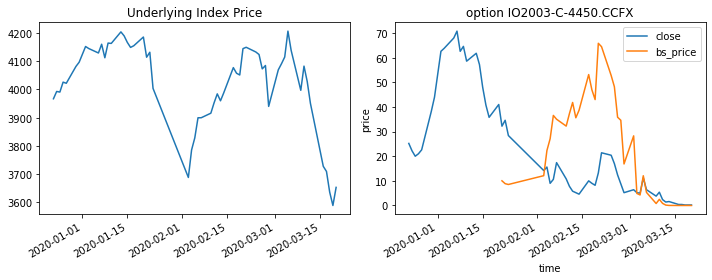

 
    option IO2003-C-4450.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : 137.9 %
    Std                 : 234.62 %
    Max (in abs value)  : 740.49% (2020-02-14)
    ---------------------------
    


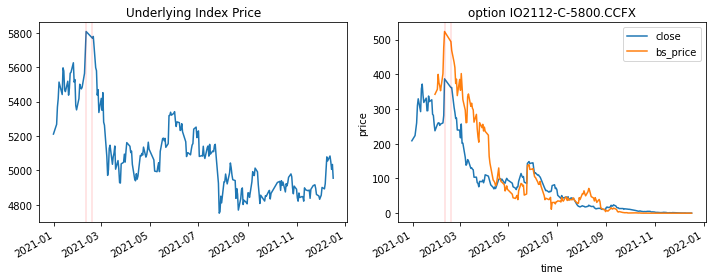

 
    option IO2112-C-5800.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : -0.63 %
    Std                 : 90.86 %
    Max (in abs value)  : 225.78% (2021-08-04)
    ---------------------------
    


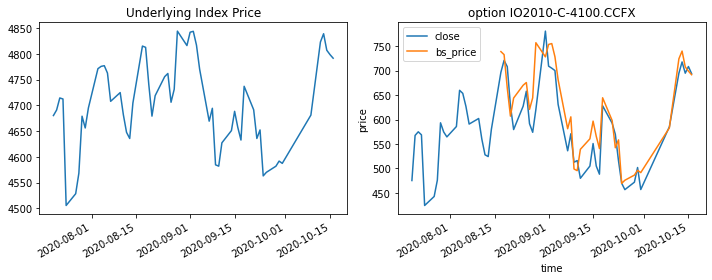

 
    option IO2010-C-4100.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : 4.27 %
    Std                 : 6.02 %
    Max (in abs value)  : 22.0% (2020-08-28)
    ---------------------------
    


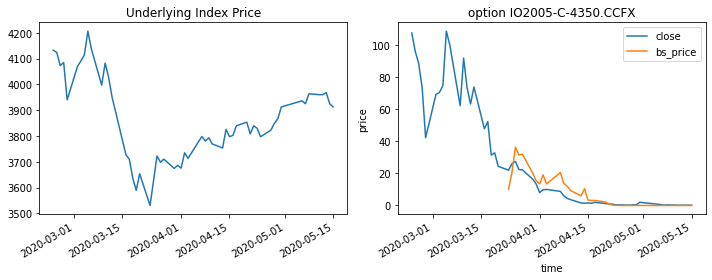

 
    option IO2005-C-4350.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : 20.22 %
    Std                 : 148.46 %
    Max (in abs value)  : 648.51% (2020-04-14)
    ---------------------------
    


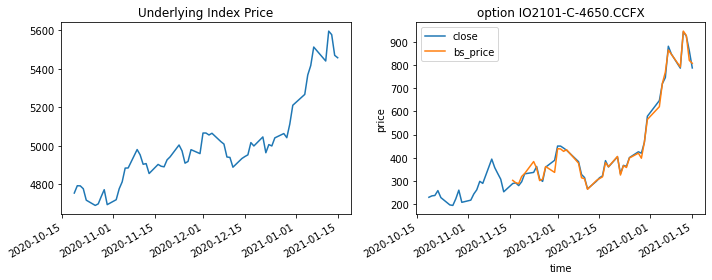

 
    option IO2101-C-4650.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : -0.46 %
    Std                 : 3.85 %
    Max (in abs value)  : 13.9% (2020-11-23)
    ---------------------------
    


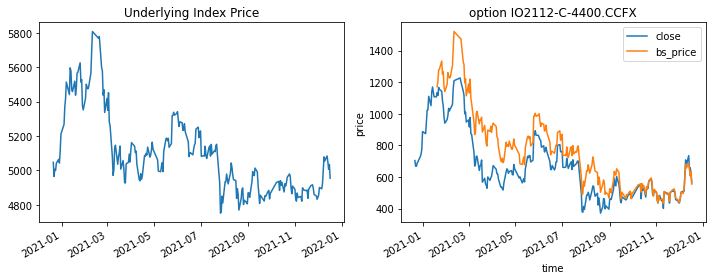

 
    option IO2112-C-4400.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : 17.35 %
    Std                 : 14.07 %
    Max (in abs value)  : 56.59% (2021-03-22)
    ---------------------------
    


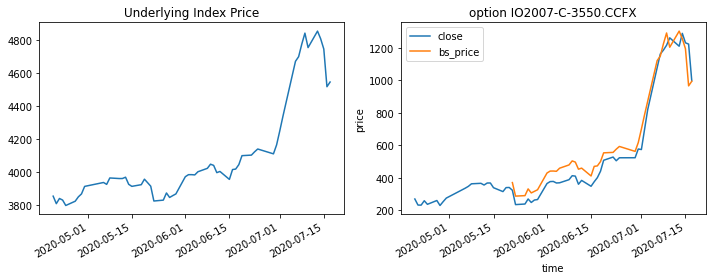

 
    option IO2007-C-3550.CCFX
    difference% = (bs_price - real_price) / real_price 
    ---------------------------
    Mean                : 12.94 %
    Std                 : 10.48 %
    Max (in abs value)  : 25.75% (2020-06-11)
    ---------------------------
    


In [16]:
import warnings
warnings.filterwarnings('ignore')

output_file = 'result_analysis.csv'

# result analysis
for each in test_options2:
    option = Option(each)
    # plot the graphs 
    bs_price, real_price = plot_real_BSres(option, volatility_window)
    mean, std, max_dif, max_date = model_evaluation(bs_price, real_price, option.get_code())
    result_to_file(output_file, option, volatility_window, mean, std, max_dif, max_date)


# Notes

**2022.3.10  Meeting Notes**

To make the simulation as accurate as possible (todo):
- risk-free rate
- change volatility window, e.g. try 10 days window
- look at the graphs that has big gap and try to figure out what the problem is
- output the results in a better way, need to compare and record results of different hyperparameters
- add model evaluation metrics
- add readme/ Latex file to explain all the parameters, details

**2022.3.20**  
- Created a log file:'result_analsys.csv'.
- Need to add a new feature: label the date when underlying price = strike price of the option
- Need to search what other people have done in Github
- Need to get familar to Github

**2022.3.23**
- Added the feature: label the at the money dates
- Fixed the bug of getting the date when gap is max